Tracks after filtering: 2617
   track_index  lifetime  max_size_points  mean_size_points  merges_total  \
0          237         1            244.0        244.000000             0   
1          238         3            930.0        399.000000             1   
2          239         3            645.0        307.666656             1   
3          240         1             92.0         92.000000             0   
4          241         5            992.0        540.400024             2   

   splits_total  mass_flux_metric merge_class  merged_flag  
0             0      88766.867188           0        False  
1             2     390246.718750           1         True  
2             2     277316.093750           1         True  
3             0      -6590.186523           0        False  
4             2    -145929.593750           2         True  


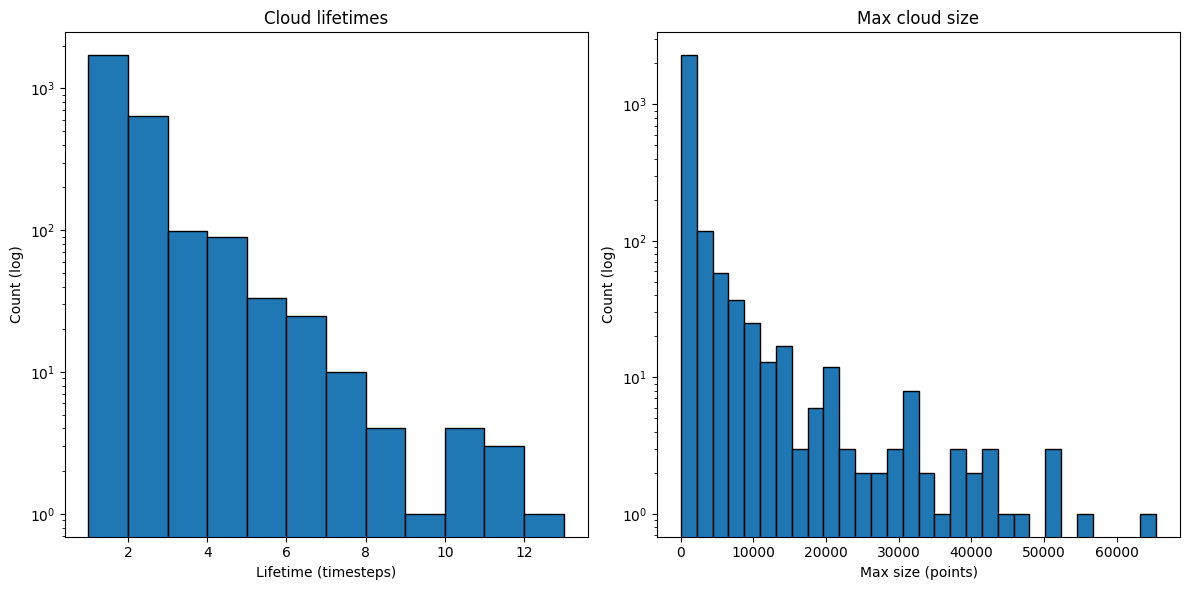

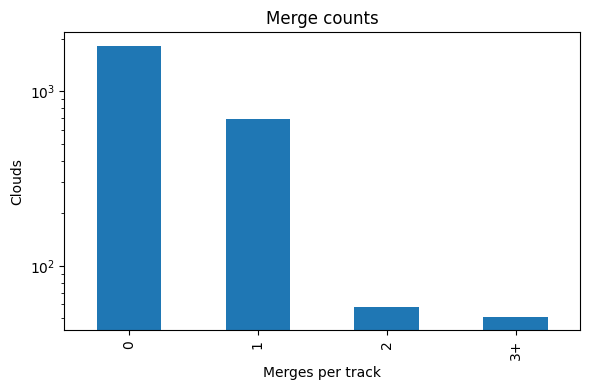

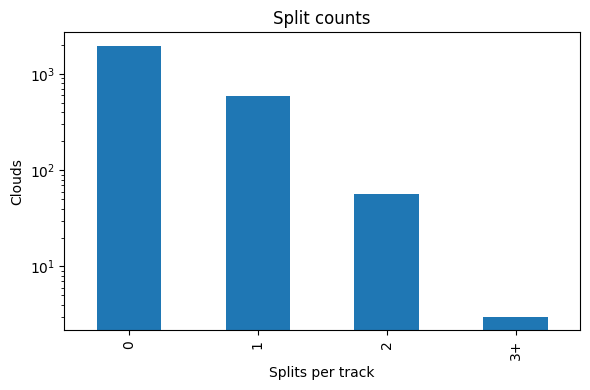

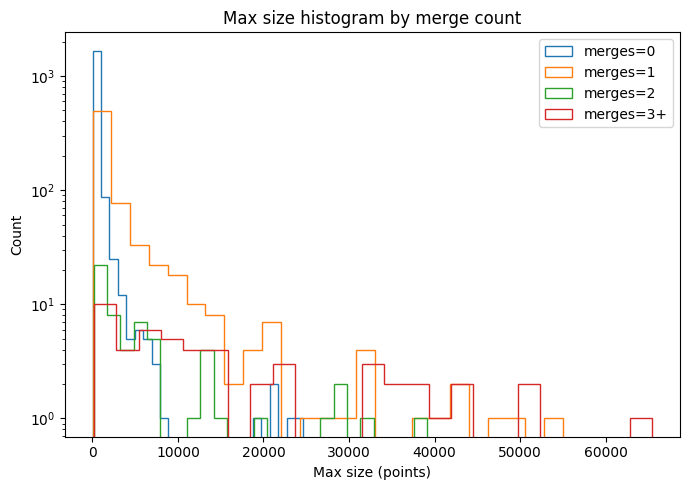

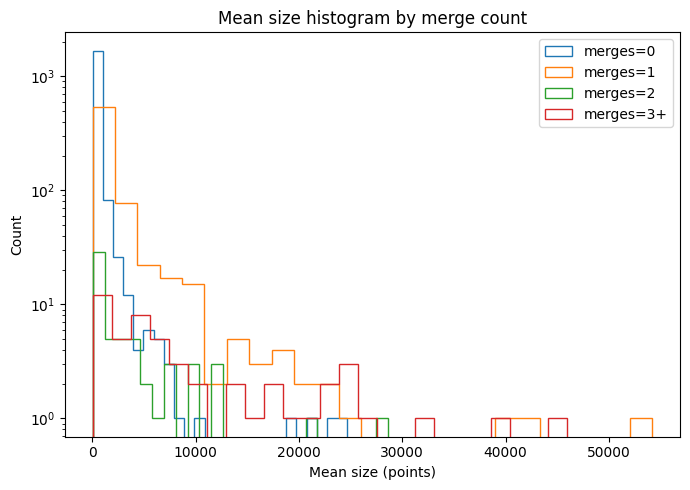

In [46]:
# PARAMETERS
nc_file = "../cloud_results.nc"
min_max_size_points = 10        # Track must reach at least this many voxels once
min_lifetime_steps = 1        # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns

# ---------------- Core extraction & processing ---------------- #
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        return np.ma.filled(var[:], np.nan) if var is not None else None
    with Dataset(nc_path) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])
        

        # optionals (properly sliced)
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)
        surface_area = read_opt(ds, 'surface_area')
        

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        surface_area=surface_area,
        w_per_level=w_per_level,
    )






def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])                  # already filled
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        # timesteps where size is real (not NaN and >0)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        # Safe sums (arrays are plain ndarrays now)
        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if physical time integration needed
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)


def infer_voxel_volumes(height, dx, dy):
    # Derive per-level thickness (Δz). Last level thickness = median of previous (fallback)
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    # Return per-level voxel volume (m3)
    return dx * dy * dz


def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))



# Remove the density plots: plot_size_distributions

# ---------------- Plotting helpers ---------------- #
def plot_basic_histograms(df):
    """Basic histograms of lifetimes and max sizes."""
    if df.empty:
        print("No tracks after filtering.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    life_max = int(df.lifetime.max())
    axes[0].hist(df.lifetime, bins=range(1, life_max + 2), edgecolor='black')
    axes[0].set_xlabel("Lifetime (timesteps)")
    axes[0].set_ylabel("Count (log)")
    axes[0].set_title("Cloud lifetimes")
    axes[0].set_yscale('log')
    axes[1].hist(df.max_size_points, bins=30, edgecolor='black')
    axes[1].set_xlabel("Max size (points)")
    axes[1].set_ylabel("Count (log)")
    axes[1].set_title("Max cloud size")
    axes[1].set_yscale('log')
    plt.tight_layout()

def plot_merge_frequency_counts(df):
    counts = df['merge_class'].value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Merges per track")
    plt.yscale('log')
    plt.title("Merge counts")
    plt.tight_layout()

def plot_split_frequency_counts(df):
    def scat(s):
        if s == 0: return "0"
        if s == 1: return "1"
        if s == 2: return "2"
        return "3+"
    counts = df.splits_total.map(scat).value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Splits per track")
    plt.yscale('log')
    plt.title("Split counts")
    plt.tight_layout()

def plot_size_histogram(df, which='max', bins=30, log=False):
    metric = 'max_size_points' if which=='max' else 'mean_size_points'
    plt.figure(figsize=(7,5))
    order = ["0","1","2","3+"]
    for cls in order:
        subset = df[df.merge_class == cls][metric]
        if subset.empty: 
            continue
        plt.hist(subset, bins=bins, histtype='step', label=f"merges={cls}", log=log)
    plt.xlabel(f"{which.capitalize()} size (points)")
    plt.ylabel("Count" + (" (log)" if log else ""))
    plt.yscale('log')
    plt.title(f"{which.capitalize()} size histogram by merge count")
    plt.legend()
    plt.tight_layout()

# ---------------- Run pipeline ---------------- #
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # still optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)

df_tracks = categorize_merges(df_tracks)

print(f"Tracks after filtering: {len(df_tracks)}")
print(df_tracks.head())

# Basic overview histograms first
plot_basic_histograms(df_tracks)

# Other summaries
plot_merge_frequency_counts(df_tracks)
plot_split_frequency_counts(df_tracks)
plot_size_histogram(df_tracks, which='max', bins=25, log=False)
plot_size_histogram(df_tracks, which='mean', bins=25, log=False)
plt.show()

# Are merged clouds responsible for a disproportionate share of convective mass flux compared to single clouds?

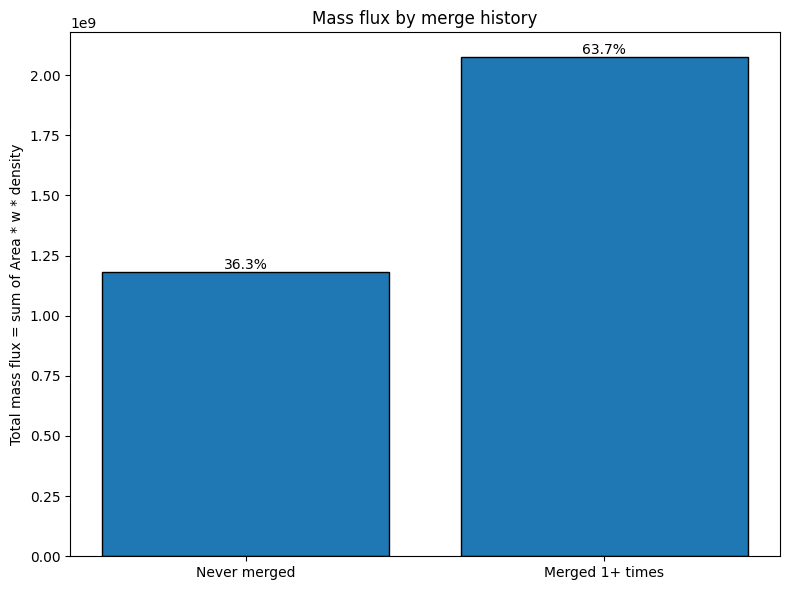

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset

def sum_mass_flux_by_merge_status(nc_file):
    """
    Sums mass flux for merged and non-merged clouds at each timestep,
    avoiding double-counting due to merges.
    Returns total mass flux for each category.
    """
    with Dataset(nc_file) as ds:
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)  # (track, time)
        valid_track = np.asarray(ds.variables['valid_track'][:])         # (track,)
        size = np.ma.filled(ds.variables['size'][:], np.nan)             # (track, time)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)  # (track, time)

        n_tracks, n_time = mass_flux.shape

        # For each timestep, sum mass flux for all clouds present, grouped by merge status
        merged_flux = 0.0
        non_merged_flux = 0.0

        for t in range(n_time):
            mask = (valid_track == 1) & np.isfinite(size[:, t]) & (size[:, t] > 0)
            merged_mask = mask & (merges_count[:, t] > 0)
            non_merged_mask = mask & (merges_count[:, t] == 0)
            merged_flux += np.nansum(mass_flux[merged_mask, t])
            non_merged_flux += np.nansum(mass_flux[non_merged_mask, t])

        return non_merged_flux, merged_flux

# Compute total mass flux for merged and non-merged clouds
non_merged_flux, merged_flux = sum_mass_flux_by_merge_status("../cloud_results.nc")

# Plot
labels = ['Never merged', 'Merged 1+ times']
values = [non_merged_flux, merged_flux]
plt.figure(figsize=(8,6))
plt.bar(labels, values, edgecolor='black')
plt.ylabel("Total mass flux = sum of Area * w * density")
plt.title("Mass flux by merge history")
if sum(values) > 0:
    pct = 100 * np.array(values) / sum(values)
    for i, (p) in enumerate(pct):
        plt.text(i, values[i], f"{p:.1f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()

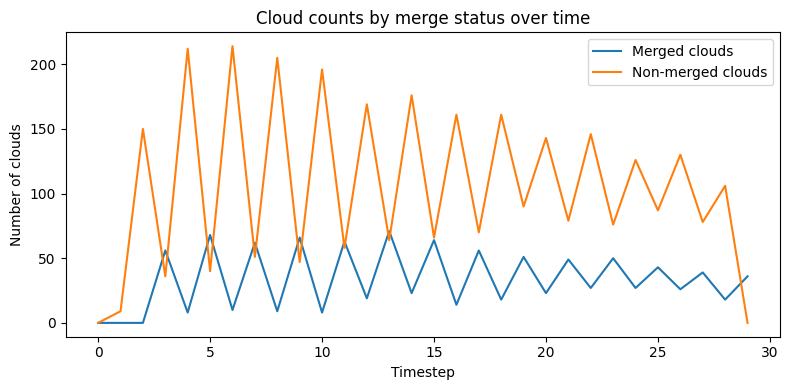

In [33]:
def count_clouds_by_merge_status(nc_file):
    with Dataset(nc_file) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        n_tracks, n_time = size.shape

        merged_counts = []
        non_merged_counts = []
        for t in range(n_time):
            mask = (valid_track == 1) & np.isfinite(size[:, t]) & (size[:, t] > 0)
            merged_mask = mask & (merges_count[:, t] > 0)
            non_merged_mask = mask & (merges_count[:, t] == 0)
            merged_counts.append(np.sum(merged_mask))
            non_merged_counts.append(np.sum(non_merged_mask))
        return np.array(merged_counts), np.array(non_merged_counts)

merged_counts, non_merged_counts = count_clouds_by_merge_status("../cloud_results.nc")
plt.figure(figsize=(8,4))
plt.plot(merged_counts, label='Merged clouds')
plt.plot(non_merged_counts, label='Non-merged clouds')
plt.xlabel("Timestep")
plt.ylabel("Number of clouds")
plt.title("Cloud counts by merge status over time")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
mean_merged_flux = merged_flux / merged_counts.sum()
mean_non_merged_flux = non_merged_flux / non_merged_counts.sum()
print(f"Mean mass flux per merged cloud: {mean_merged_flux:.2e}")
print(f"Mean mass flux per non-merged cloud: {mean_non_merged_flux:.2e}")

Mean mass flux per merged cloud: 2.07e+06
Mean mass flux per non-merged cloud: 3.76e+05


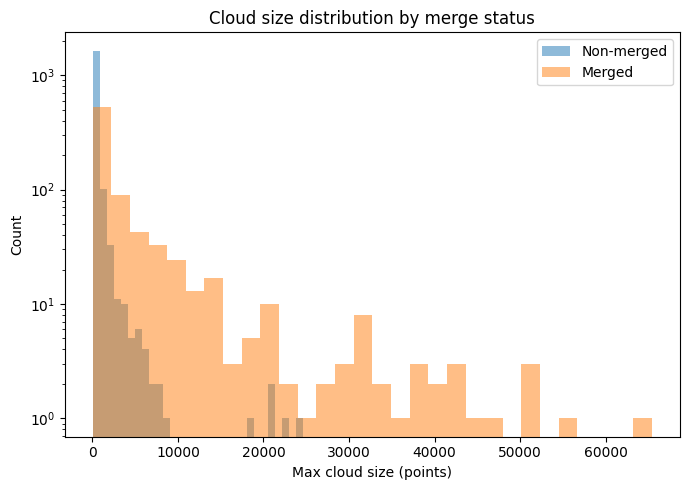

In [35]:
# If you have a DataFrame of tracks:
plt.figure(figsize=(7,5))
for label, flag in zip(['Non-merged', 'Merged'], [False, True]):
    subset = df_tracks[df_tracks.merged_flag == flag]
    plt.hist(subset.max_size_points, bins=30, alpha=0.5, label=label)
plt.xlabel("Max cloud size (points)")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Cloud size distribution by merge status")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23077/1259573898.py:25: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


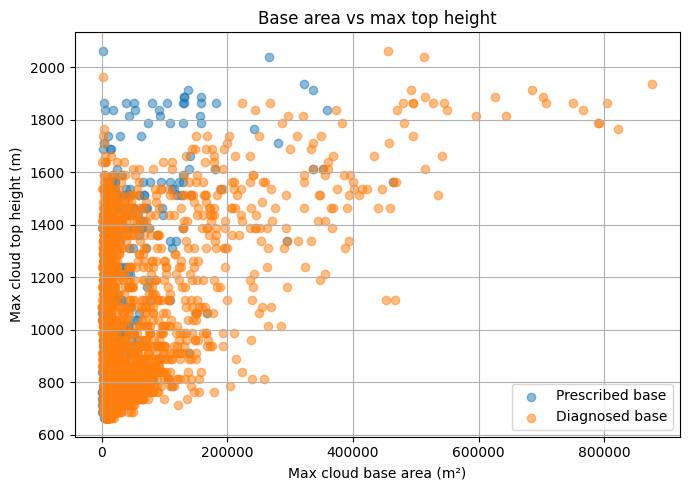

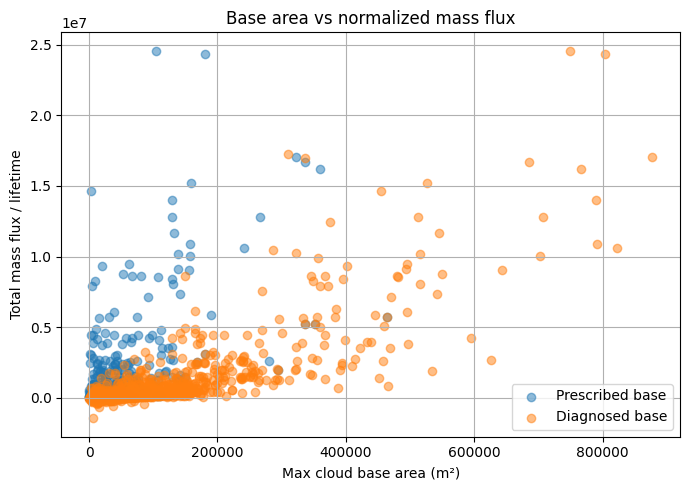

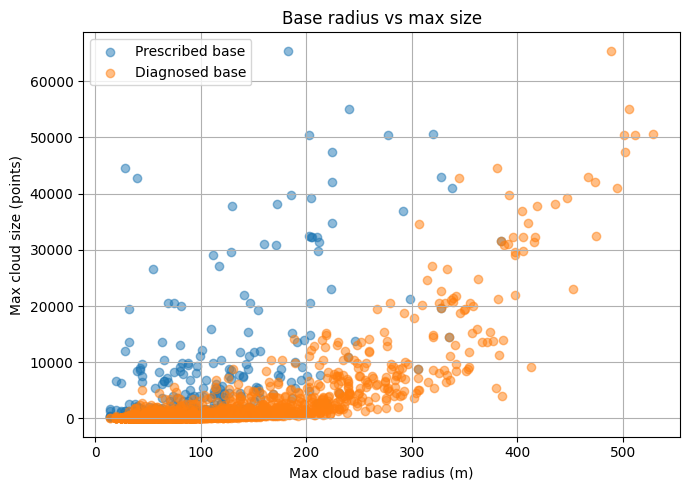

In [36]:
def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2
area_diagnosed = np.pi * max_diagnosed**2

# Relationship 1: base area vs max cloud top height
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (m²)")
plt.ylabel("Max cloud top height (m)")
plt.title("Base area vs max top height")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (m²)")
plt.ylabel("Total mass flux / lifetime")
plt.title("Base area vs normalized mass flux")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size
plt.figure(figsize=(7,5))
plt.scatter(max_prescribed, df_tracks.max_size_points, alpha=0.5, label='Prescribed base')
plt.scatter(max_diagnosed, df_tracks.max_size_points, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base radius (m)")
plt.ylabel("Max cloud size (points)")
plt.title("Base radius vs max size")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

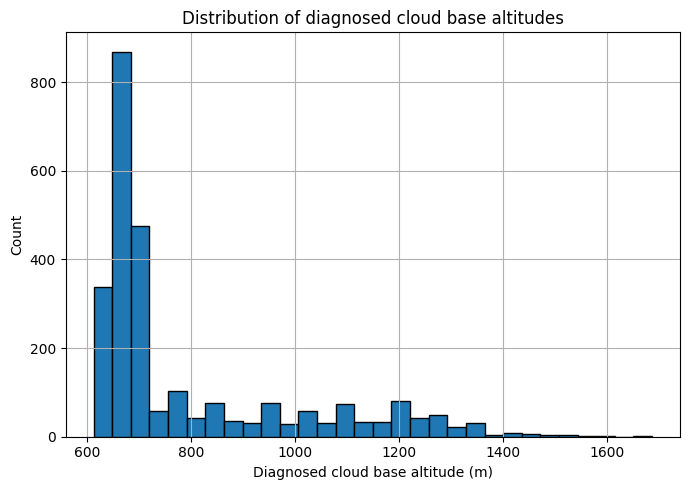

In [37]:
base_altitude = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
idx = df_tracks.track_index.values
min_base_altitude = np.nanmin(base_altitude[idx, :], axis=1)
plt.figure(figsize=(7,5))
plt.hist(min_base_altitude[~np.isnan(min_base_altitude)], bins=30, edgecolor='black')
plt.xlabel("Diagnosed cloud base altitude (m)")
plt.ylabel("Count")
plt.title("Distribution of diagnosed cloud base altitudes")
plt.grid(True)
plt.tight_layout()
plt.show()

# vertical velocity and branchiness  

Relationship between max cloud base w and max cloud size (and max cloud top height, and max branchiness)

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23077/2462475709.py:16: RuntimeWarning: All-NaN slice encountered
  max_updraft = np.nanmax(w_vals_pos, axis=(1,2))


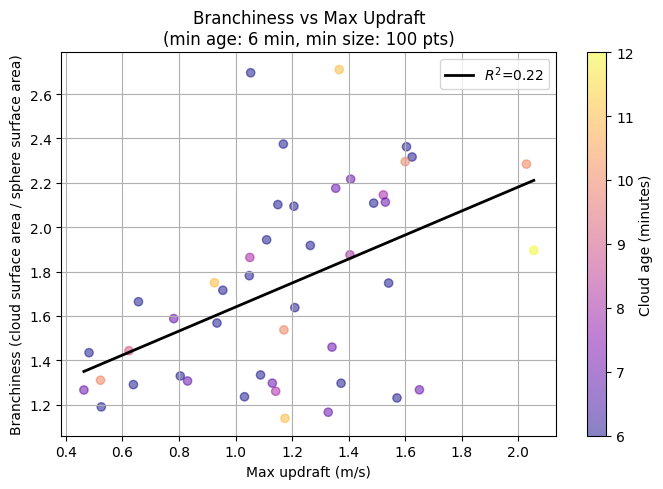

Linear fit: branchiness = 0.541 * max_updraft + 1.099
R^2 = 0.222, p-value = 0.000963


In [ ]:
def extract_max_updraft_and_branchiness(raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Extracts max updraft (positive vertical velocity) and branchiness for each track.
    Branchiness is defined as max(surface_area) / sphere_surface_area,
    where sphere_surface_area is the surface area of a sphere with the same volume as the cloud.
    """
    w_per_level = raw.get('w_per_level', None)
    surface_area = raw.get('surface_area', None)
    size = raw.get('size', None)
    idx = df_tracks.track_index.values

    # Max updraft per track (ignore negative values)
    if w_per_level is not None and hasattr(w_per_level, 'shape') and len(w_per_level.shape) == 3:
        w_vals = w_per_level[idx, :, :]  # shape: (track, time, level)
        w_vals_pos = np.where(w_vals > 0, w_vals, np.nan)
        max_updraft = np.nanmax(w_vals_pos, axis=(1,2))
    else:
        max_updraft = np.full(len(idx), np.nan)

    # Branchiness: max(surface_area) / sphere_surface_area per track
    if surface_area is not None and size is not None:
        max_surface_area = np.nanmax(surface_area[idx, :], axis=1)
        max_size = np.nanmax(size[idx, :], axis=1)
        voxel_volume = voxel_dx * voxel_dy * voxel_dz
        max_volume = max_size * voxel_volume

        # Surface area of a sphere with same volume: 4 * pi * (3*V/(4*pi))**(2/3)
        sphere_surface_area = 4 * np.pi * np.power(3 * max_volume / (4 * np.pi), 2/3)
        branchiness = max_surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    else:
        branchiness = np.full(len(idx), np.nan)

    return max_updraft, branchiness

# User parameters
min_age_minutes = 6  # clouds must live at least this many minutes
min_size_points = 100  # clouds must reach at least this many voxels once
dt_seconds = 60       # time step in seconds

max_updraft, branchiness = extract_max_updraft_and_branchiness(
    raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0
)
ages = df_tracks.lifetime.values * dt_seconds / 60.0  # convert to minutes
sizes = df_tracks.max_size_points.values

# Filter: valid, positive updraft, min age, min size
valid = (
    np.isfinite(branchiness) &
    np.isfinite(max_updraft) &
    (max_updraft > 0) &
    (ages >= min_age_minutes) &
    (sizes >= min_size_points)
)
from scipy.stats import linregress

plt.figure(figsize=(7,5))
sc = plt.scatter(max_updraft[valid], branchiness[valid], c=ages[valid], cmap='plasma', alpha=0.5)

# Fit a linear regression line (least squares)
slope, intercept, r_value, p_value, std_err = linregress(max_updraft[valid], branchiness[valid])
x_fit = np.linspace(np.nanmin(max_updraft[valid]), np.nanmax(max_updraft[valid]), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='black', lw=2, label=f'$R^2$={r_value**2:.2f}')

plt.xlabel("Max updraft (m/s)")
plt.ylabel("Branchiness (cloud surface area / sphere surface area)")
plt.title(f"Branchiness vs Max Updraft\n(min age: {min_age_minutes} min, min size: {min_size_points} pts)")
plt.colorbar(sc, label="Cloud age (minutes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Linear fit: branchiness = {slope:.3f} * max_updraft + {intercept:.3f}")
print(f"R^2 = {r_value**2:.3f}, p-value = {p_value:.3g}")

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23077/2247371545.py:16: RuntimeWarning: All-NaN slice encountered
  max_updraft = np.nanmax(w_vals_pos, axis=(1,2))


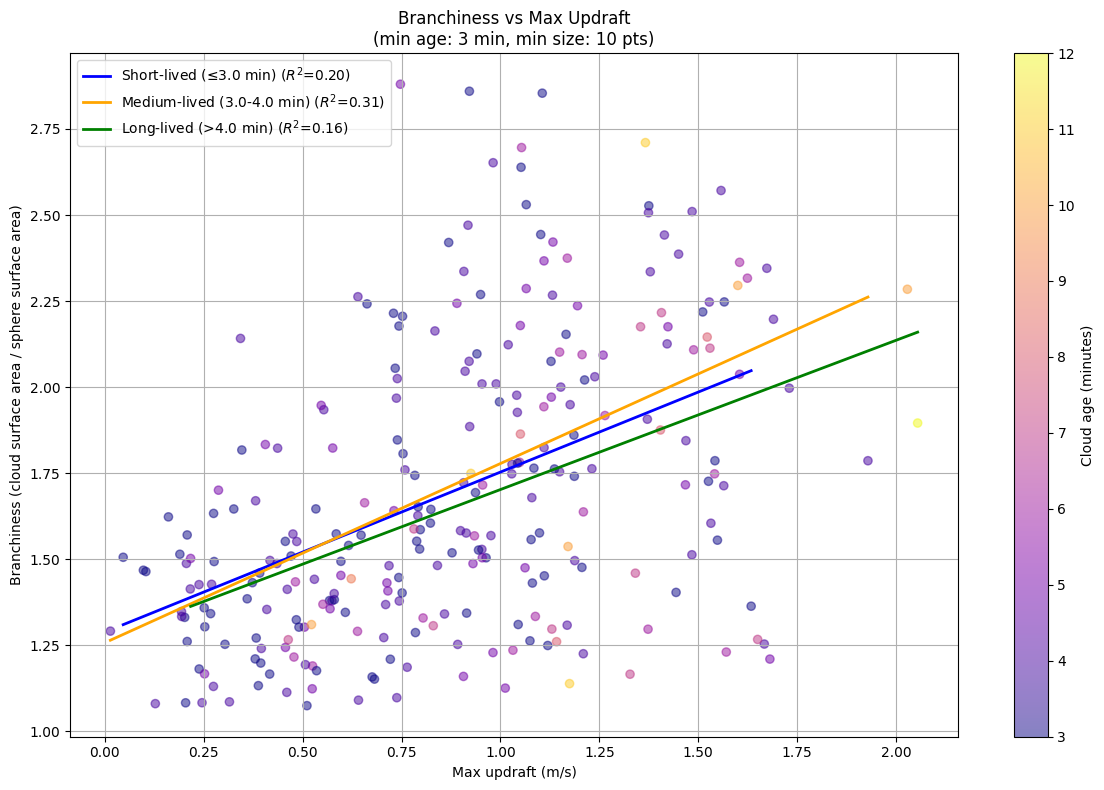

In [72]:
def extract_max_updraft_and_branchiness(raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0):
    """
    Extracts max updraft (positive vertical velocity) and branchiness for each track.
    Branchiness is defined as max(surface_area) / sphere_surface_area,
    where sphere_surface_area is the surface area of a sphere with the same volume as the cloud.
    """
    w_per_level = raw.get('w_per_level', None)
    surface_area = raw.get('surface_area', None)
    size = raw.get('size', None)
    idx = df_tracks.track_index.values

    # Max updraft per track (ignore negative values)
    if w_per_level is not None and hasattr(w_per_level, 'shape') and len(w_per_level.shape) == 3:
        w_vals = w_per_level[idx, :, :]  # shape: (track, time, level)
        w_vals_pos = np.where(w_vals > 0, w_vals, np.nan)
        max_updraft = np.nanmax(w_vals_pos, axis=(1,2))
    else:
        max_updraft = np.full(len(idx), np.nan)

    # Branchiness: max(surface_area) / sphere_surface_area per track
    if surface_area is not None and size is not None:
        max_surface_area = np.nanmax(surface_area[idx, :], axis=1)
        max_size = np.nanmax(size[idx, :], axis=1)
        voxel_volume = voxel_dx * voxel_dy * voxel_dz
        max_volume = max_size * voxel_volume

        # Surface area of a sphere with same volume: 4 * pi * (3*V/(4*pi))**(2/3)
        sphere_surface_area = 4 * np.pi * np.power(3 * max_volume / (4 * np.pi), 2/3)
        branchiness = max_surface_area / np.where(sphere_surface_area > 0, sphere_surface_area, np.nan)
    else:
        branchiness = np.full(len(idx), np.nan)

    return max_updraft, branchiness

# User parameters
min_age_minutes = 3   # clouds must live at least this many minutes
min_size_points = 10  # clouds must reach at least this many voxels once
dt_seconds = 60       # time step in seconds

max_updraft, branchiness = extract_max_updraft_and_branchiness(
    raw, df_tracks, voxel_dx=25.0, voxel_dy=25.0, voxel_dz=25.0
)
ages = df_tracks.lifetime.values * dt_seconds / 60.0  # convert to minutes
sizes = df_tracks.max_size_points.values

# Filter: valid, positive updraft, min age, min size
valid = (
    np.isfinite(branchiness) &
    np.isfinite(max_updraft) &
    (max_updraft > 0) &
    (ages >= min_age_minutes) &
    (sizes >= min_size_points)
)


from scipy.stats import linregress

# ...existing code...

plt.figure(figsize=(12,8))
sc = plt.scatter(max_updraft[valid], branchiness[valid], c=ages[valid], cmap='plasma', alpha=0.5)

# Tertile split by lifetime (ages)
ages_valid = ages[valid]
updraft_valid = max_updraft[valid]
branchiness_valid = branchiness[valid]

# Get tertile edges
tertiles = np.percentile(ages_valid, [33.33, 66.67])
short_mask = ages_valid <= tertiles[0]
medium_mask = (ages_valid > tertiles[0]) & (ages_valid <= tertiles[1])
long_mask = ages_valid > tertiles[1]

# Fit lines for each group
colors = ['blue', 'orange', 'green']
labels = [
    f'Short-lived (≤{tertiles[0]:.1f} min)',
    f'Medium-lived ({tertiles[0]:.1f}-{tertiles[1]:.1f} min)',
    f'Long-lived (>{tertiles[1]:.1f} min)'
]
masks = [short_mask, medium_mask, long_mask]

for i, mask in enumerate(masks):
    slope, intercept, r_value, _, _ = linregress(updraft_valid[mask], branchiness_valid[mask])
    x_fit = np.linspace(np.nanmin(updraft_valid[mask]), np.nanmax(updraft_valid[mask]), 100)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, color=colors[i], lw=2, label=f'{labels[i]} ($R^2$={r_value**2:.2f})')

plt.xlabel("Max updraft (m/s)")
plt.ylabel("Branchiness (cloud surface area / sphere surface area)")
plt.title(f"Branchiness vs Max Updraft\n(min age: {min_age_minutes} min, min size: {min_size_points} pts)")
plt.colorbar(sc, label="Cloud age (minutes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()